In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
from sqlalchemy import text

plt.style.use("ggplot")

# Accessing data in Nivabasen (Oracle)

Nivabasen is the name of NIVA's Oracle database instance. It has been used for many years and is still a core component of NIVA's data system. Depending on what data you need, there are several different options for accessing data in Nivabasen.

## 1. Aquamonitor-Python and AquamonitR

**This is the recommended approach** for accessing "standard" water chemistry data, such as data analysed by NIVALab. 

[Aquamonitor-Python](https://github.com/NIVANorge/Aquamonitor-Python) and [AquamonitR](https://github.com/NIVANorge/aquamonitR/) both use the Aquamonitor API, which means they provide programmatic access to the same data that is available via the [Aquamonitor website](https://aquamonitor.niva.no/portal/). Using these libraries is preferable to the other methods described in this notebook because:

 * Using the Aquamonitor API guarantees that you are accessing the "official" and most up-to-date versions of the data (i.e. the same data available from the Aquamonitor website)
 
 * All NIVA users can login to the API using their NIVA credentials (i.e. there is no need for a separate Oracle account)
 
 * Using the API is safer/more robust than managing a direct database connection
 
**If you just need to access "standard" water chemistry data, please try these libraries first**. A complete example for Aquamonitor-Python is [here](https://nbviewer.org/github/NIVANorge/Aquamonitor-Python/blob/master/examples/query_chem.ipynb) and an equivalent notebook for AquamonitR is [here](https://nbviewer.org/github/NIVANorge/aquamonitR/blob/main/examples/query_chem.ipynb).

<div class="alert alert-warning">
    <b>Note:</b> At the time of writing, the AquamonitR library needs maintenance to bring it up-to-date with the latest version of the API. If you work with R and are interested in contributing, please contact <a href="mailto:james.sample@niva.no">James Sample</a>.
</div>

## 2. Using nivapy

If the data you need are not accessible via the Aquamonitor API, you can use `nivapy` to create a direct connection to the Oracle database. This allows you to access data in a more flexible way and you can also create you own custom queries (assuming you are familiar with the database structure and Oracle-SQL).

Before you can create a direct database connection, you first **need an Oracle user account** - please contact [Jens Vedal](mailto:Jens.Vedal@niva.no) to get started.

### 2.1. Connect to the database

The first step is to connect to Nivabasen. The database engine object (`eng` in the code below) can then be used to submit queries and retrieve data.

When prompted, be sure to **enter your Oracle credentials**, not your general NIVA credentials.

In [2]:
# Connect to Oracle
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


### 2.2. Query water chemistry

Within Nivabasen there are two main databases containing water chemistry and biology data: `nivadatabase`, which is the main database underlying Aquamonitor, and `resa2`, which is a legacy database that is nevertheless still important for some workflows. In most cases, **users should focus on the data in `nivadatabasen`**, as this has better quality assurance and is generally considered as the "reference" or "official" copy of the data (e.g. for reporting purposes).

Nivapy's "data access" (`da`) module provides the following convenience functions for querying data in `nivadatabase`:

 * `select_ndb_projects`. Gets a dataframe of all projects in the database
 * `select_ndb_stations`. Gets a dataframe of all stations in the database
 * `select_ndb_project_stations`. Gets a dataframe of all stations associated with a specified list of projects
 * `select_ndb_station_parameters`. Gets a dataframe of water chemsitry parameters available for a specified list of stations within a specified date range
 * `select_ndb_water_chemistry`. Gets a dataframe of water chemistry for a specified set of stations and parameters with a given date range
 * `select_ndb_stations_in_polygon`. Performs a spatial intersection to identify stations in `nivadatabase` within a given area of interest (e.g. a shapefile). This is useful for quickly identifying which stations and parameters are available within your study area
 
In addition, there is an equivalent set of functions named `select_resa_XXXX` which perform exactly the same queries against the legacy `resa2` database. RESA2 is still an important database at NIVA, but you should only use data from it if you are familiar with the database's history and are aware of the caveats and limitations (see above).

In the example below, we query data from the 2019 "1000 Lakes" survey. Note that **these data are also available using Aquamonitor-Python, which should be preferred in most circumstances** (see above). This example is just for comparison with the Aquamonitor-Python approach documented [here](https://nbviewer.org/github/NIVANorge/Aquamonitor-Python/blob/master/examples/query_chem.ipynb).

#### 2.2.1. Explore projects

In [3]:
# Get all projects in nivadatabase
proj_df = nivapy.da.select_ndb_projects(eng)
proj_df.head()

1542 projects in the NIVADATABASE.


,project_id,project_name,project_description
0,1,xxx,None
1,55,PARCOM_Aquateam,None
2,56,PARCOM_NIVA,None
3,58,MAR_BOK,Fagdata
4,59,MAR_IMA,Fagdata


In [4]:
# Filter to just the project for the 2019 '1000 Lakes' survey
proj_df = proj_df.query(
    "project_name.str.contains('Nasjonal Innsjøundersøkelse 2019')", engine="python"
)
proj_df

,project_id,project_name,project_description
1192,12433,Nasjonal Innsjøundersøkelse 2019,1000-sjøer undersøkelse gjennomført i 2019


#### 2.2.2. Explore stations

In [5]:
# Get ALL stations in the database (i.e. from all projects)
# May take a while
stn_df = nivapy.da.select_ndb_stations(eng)
stn_df.head()

30537 stations in the NIVADATABASE.


,station_id,station_code,station_name,station_type,latitude,longitude
0,3561,BUSEDRA,Drammenselva,Elv,59.753992,10.009029
1,3562,FINEALT,Altaelva.,Elv,69.901142,23.287058
2,3563,NOREVEF,Vefsna.,Elv,65.749464,13.239104
3,3564,ROGEORR,Orreelva,Elv,58.731430,5.529362
4,3565,ROGESUL,Suldalslågen.,Elv,59.482215,6.259855


In [6]:
# Usually we are interested in stations for specific project(s)
# 'proj_df' can contain one or more projects; see docstring for details
stn_df = nivapy.da.select_ndb_project_stations(proj_df, eng, drop_dups=True)
stn_df.head()

,station_id,station_code,station_name,station_type,longitude,latitude
0,26070,221-1-2,Langtjern,Innsjø,11.850274,59.808643
1,26071,101-2-7,Hokksjøen,Innsjø,11.563586,59.004423
2,26072,402-2-13,Sætertjern,Innsjø,12.446711,60.060222
3,26073,419-1-25,Mjøgsjøen,Innsjø,11.842186,60.328578
4,26074,425-2-2,Kottern,Innsjø,12.517008,60.590729


In [7]:
# Show stations on a simple interactive map
nivapy.spatial.quickmap(
    stn_df, cluster=True, aerial_imagery=True, kartverket=True, popup="station_code"
)

#### 2.2.3. Explore parameters

In [8]:
# Find water chemsitry parameters available for a set of stations within a period of interest
st_dt = "2019-01-01"
end_dt = "2019-12-31"
par_df = nivapy.da.select_ndb_station_parameters(stn_df, st_dt, end_dt, eng)
par_df.head()

41 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
0,462,Al,µg/l
1,1282,Al/IL,µg/l
2,466,Alk_4.5,mmol/l
3,2557,Al/L,µg/l
4,1281,Al/R,µg/l


In [9]:
# Filter to parameters of interest
par_list = ["TOTN", "TOTP", "TOC"]
par_df = par_df.query("parameter_name in @par_list")
par_df

,parameter_id,parameter_name,unit
36,257,TOC,mg/l
38,11,TOTP,µg/l


#### 2.2.4. Get water chemistry

In [10]:
# Get water chemistry for selected stations, parameters and dates
# See docstring for details - especially regarding duplicates
wc_df, dup_df = nivapy.da.select_ndb_water_chemistry(
    stn_df, par_df, st_dt, end_dt, eng, lod_flags=False, drop_dups=True
)
wc_df.head()

/opt/conda/lib/python3.13/site-packages/nivapy3/da.py:870: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["parameter_name"].fillna("", inplace=True)
/opt/conda/lib/python3.13/site-packages/nivapy3/da.py:871: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

,station_id,station_code,station_name,sample_date,depth1,depth2,TOC_mg/l,TOTP_µg/l
,,,,,,,,
0,26070,221-1-2,Langtjern,2019-10-25,0,0,20.0,11.0
1,26071,101-2-7,Hokksjøen,2019-10-25,0,0,24.2,10.0
2,26072,402-2-13,Sætertjern,2019-10-25,0,0,20.3,9.0
3,26073,419-1-25,Mjøgsjøen,2019-10-25,0,0,25.8,10.0
4,26074,425-2-2,Kottern,2019-10-25,0,0,16.8,11.0


#### 2.2.5. Simple plotting

Much more sophisticated plots are possible, but nivapy includes some basic functions for quick visualisation.

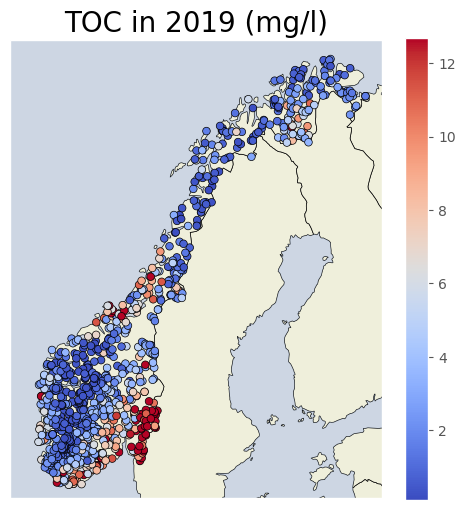

In [11]:
# Join station co-ordinates to water chemistry
df = pd.merge(
    wc_df, stn_df[["station_id", "longitude", "latitude"]], how="left", on="station_id"
)

# Plot
nivapy.spatial.plot_norway_point_data(
    df,
    "TOC_mg/l",
    lat="latitude",
    lon="longitude",
    vmax_pct=0.95,
    cmap="coolwarm",
    s=30,
    title="TOC in 2019 (mg/l)",
    out_path=None,
)

### 2.3. Advanced usage

<div class="alert alert-danger">
    The examples in this section require knowledge of the structure of Nivabasen and SQL. Depending on the privileges allocated to your Oracle user, <b>you could do a lot of damage to the database</b> by executing arbitrary SQL. Please only run your own queries if you know what you're doing and <b>test your code carefully before sending it to the database</b>. 
</div>

In [12]:
# Simple example of arbitrary SQL
stn_id = 12711
samp_dt = "2016-06-28"

samp_dt = dt.datetime.strptime(samp_dt, "%Y-%m-%d").date()
sql = text(
    "SELECT * FROM resa2.water_samples "
    "WHERE station_id = :stn_id "
    "AND TRUNC(sample_date) = :samp_dt"
)
df = pd.read_sql(sql, eng, params={"stn_id": stn_id, "samp_dt": samp_dt})
df

,water_sample_id,station_id,sample_date,depth1,depth2,project_id,wl_testno,wl_serialno,wl_marking,wl_ident,remark,entered_by,entered_date
0,657661,12711,2016-06-28,0,0,None,None,None,None,None,None,TOH,12.06.2017
